# 🩺 Classificação de Diabetes com XGBoost, LightGBM e Random Forest
Neste notebook, vamos:
- Carregar e explorar o dataset Pima Indians Diabetes
- Treinar modelos usando **XGBoost**, **LightGBM** e **Random Forest**
- Comparar o desempenho dos modelos com métricas e matrizes de confusão

In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
# 1. Carregar dataset do OpenML

data = fetch_openml(name='diabetes', version=1, as_frame=True)
df = data.frame
df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive


In [3]:
# 2. Preparar dados
X = df.drop(columns=['class'])
y = df['class'].map({'tested_negative': 0, 'tested_positive': 1})

In [4]:
# 3. Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

## 🌲 Random Forest

In [5]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest:
[[130  20]
 [ 38  43]]
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       150
           1       0.68      0.53      0.60        81

    accuracy                           0.75       231
   macro avg       0.73      0.70      0.71       231
weighted avg       0.74      0.75      0.74       231



## ⚡ XGBoost

In [6]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost:
[[124  26]
 [ 38  43]]
              precision    recall  f1-score   support

           0       0.77      0.83      0.79       150
           1       0.62      0.53      0.57        81

    accuracy                           0.72       231
   macro avg       0.69      0.68      0.68       231
weighted avg       0.72      0.72      0.72       231



/home/lecraizer/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:47:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## 💡 LightGBM

In [7]:
lgb_model = lgb.LGBMClassifier(verbose=-1)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

print("LightGBM:")
print(confusion_matrix(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb))

LightGBM:
[[125  25]
 [ 36  45]]
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       150
           1       0.64      0.56      0.60        81

    accuracy                           0.74       231
   macro avg       0.71      0.69      0.70       231
weighted avg       0.73      0.74      0.73       231



In [8]:
cat_model = CatBoostClassifier(verbose=0, random_state=42)  # verbose=0 para não ficar printando durante o fit
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)

print("CatBoost:")
print(confusion_matrix(y_test, y_pred_cat))
print(classification_report(y_test, y_pred_cat))

CatBoost:
[[130  20]
 [ 39  42]]
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       150
           1       0.68      0.52      0.59        81

    accuracy                           0.74       231
   macro avg       0.72      0.69      0.70       231
weighted avg       0.74      0.74      0.74       231



## 📊 Comparação Visual (Matrizes de Confusão)

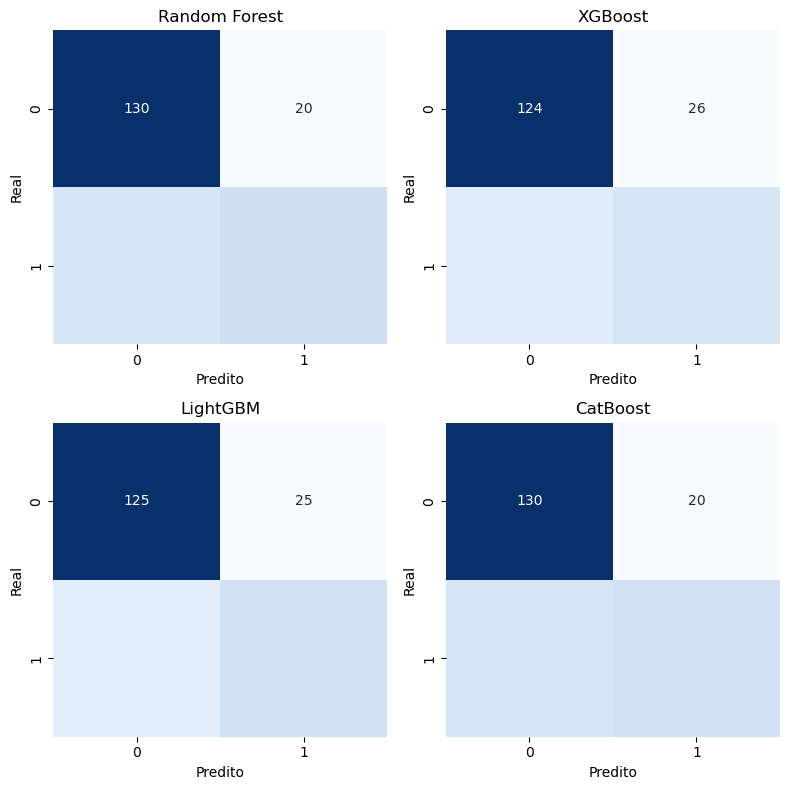

In [10]:
models = {
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'LightGBM': y_pred_lgb,
    'CatBoost': y_pred_cat
}

plt.figure(figsize=(8, 8))  # Tamanho ajustado para 2x2

for i, (name, y_pred) in enumerate(models.items(), 1):
    plt.subplot(2, 2, i)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(name)
    plt.xlabel("Predito")
    plt.ylabel("Real")

plt.tight_layout()
plt.show()

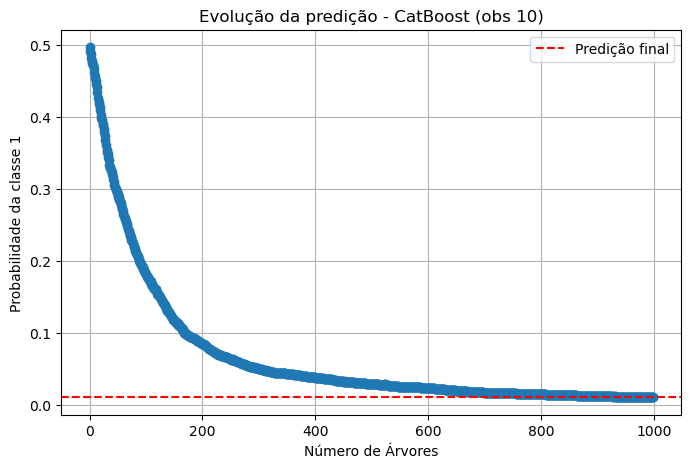

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Função sigmoide para converter RawFormulaVal em probabilidade
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Número total de árvores no modelo
n_trees = cat_model.tree_count_

# Índice da observação a ser analisada
obs = 10  # mude aqui se quiser outra observação

# Evolução da predição
evolution = []

for i in range(1, n_trees + 1):
    raw_pred = cat_model.predict(
        X_train.iloc[[obs]],  # <- sem reshape, já funciona
        prediction_type='RawFormulaVal', 
        ntree_end=i
    )[0]
    prob = sigmoid(raw_pred)
    evolution.append(prob)

# Plot
plt.figure(figsize=(8,5))
plt.plot(evolution, marker='o')
plt.title(f'Evolução da predição - CatBoost (obs {obs})')
plt.xlabel('Número de Árvores')
plt.ylabel('Probabilidade da classe 1')
plt.grid()
plt.axhline(y=evolution[-1], color='r', linestyle='--', label='Predição final')
plt.legend()
plt.show()


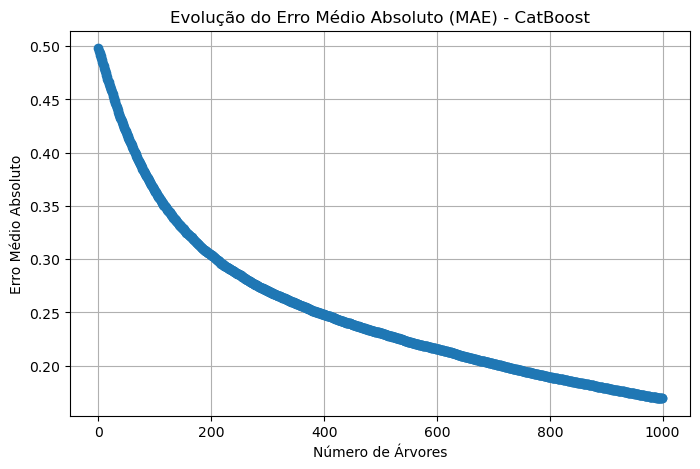

In [24]:
y_train_numeric = y_train.astype(int)  # <- Conversão correta

mae_list = []

for i in range(1, n_trees + 1):
    raw_preds = cat_model.predict(
        X_train,
        prediction_type='RawFormulaVal',
        ntree_end=i
    )
    prob_preds = sigmoid(raw_preds)
    mae = np.mean(np.abs(prob_preds - y_train_numeric))
    mae_list.append(mae)

plt.figure(figsize=(8,5))
plt.plot(mae_list, marker='o')
plt.title('Evolução do Erro Médio Absoluto (MAE) - CatBoost')
plt.xlabel('Número de Árvores')
plt.ylabel('Erro Médio Absoluto')
plt.grid()
plt.show()

## ➕ Modelos adicionais: KNN, Regressão Logística e SVM RBF

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Regressão logística
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# KNN com k=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# SVM com kernel RBF
svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Avaliação
from sklearn.metrics import classification_report
print("Regressão Logística:")
print(classification_report(y_test, y_pred_lr))
print("\nKNN (k=5):")
print(classification_report(y_test, y_pred_knn))
print("\nSVM (RBF):")
print(classification_report(y_test, y_pred_svm))

Regressão Logística:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       150
           1       0.67      0.52      0.58        81

    accuracy                           0.74       231
   macro avg       0.72      0.69      0.70       231
weighted avg       0.73      0.74      0.73       231


KNN (k=5):
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       150
           1       0.62      0.51      0.56        81

    accuracy                           0.72       231
   macro avg       0.69      0.67      0.68       231
weighted avg       0.71      0.72      0.71       231


SVM (RBF):
              precision    recall  f1-score   support

           0       0.75      0.91      0.82       150
           1       0.72      0.44      0.55        81

    accuracy                           0.74       231
   macro avg       0.74      0.68      0.69       231
weighted avg       0.74      

## 📈 Curva ROC – Todos os Modelos

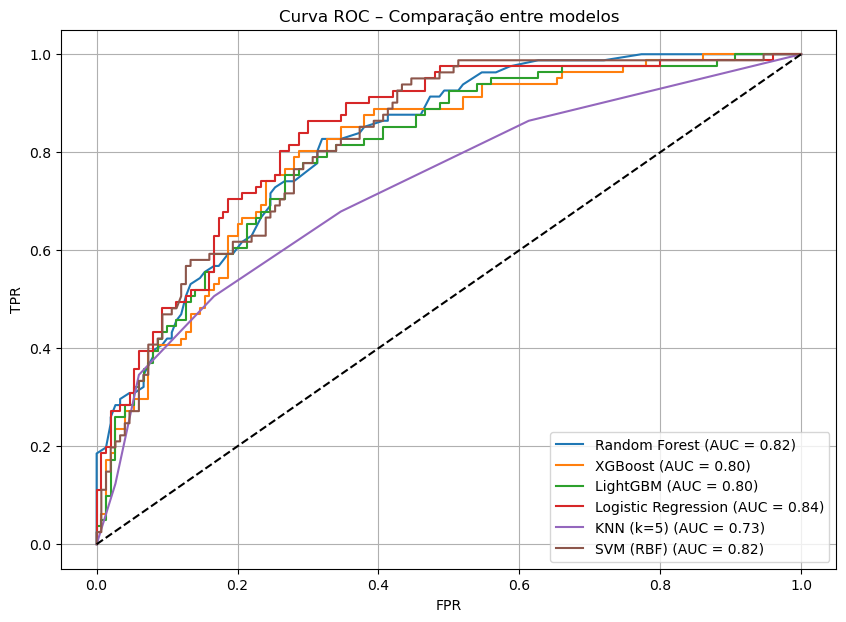

In [9]:
from sklearn.metrics import roc_curve, auc

models_probs = {
    'Random Forest': rf.predict_proba(X_test)[:, 1],
    'XGBoost': xgb_model.predict_proba(X_test)[:, 1],
    'LightGBM': lgb_model.predict_proba(X_test)[:, 1],
    'Logistic Regression': lr.predict_proba(X_test)[:, 1],
    'KNN (k=5)': knn.predict_proba(X_test)[:, 1],
    'SVM (RBF)': svm.predict_proba(X_test)[:, 1]
}

plt.figure(figsize=(10, 7))
for name, probs in models_probs.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC – Comparação entre modelos')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

O que esse resultado ensina?
1. Modelos simples podem ser altamente eficazes. A regressão logística é leve, interpretável e pode performar muito bem quando:
 
- As classes são separáveis em termos lineares
- As features estão bem normalizadas e informativas
- O problema não exige modelar interações complexas

2. Boosting não é mágica — é técnica! Boosting brilha especialmente quando há:

- Ruído nos dados
- Interações complexas entre variáveis
- Problemas não linearmente separáveis
- Desbalanceamento, etc.

3. Justifica aprender comparação entre modelos:

- Essa situação mostra por que avaliamos vários algoritmos — nem sempre o mais sofisticado é o melhor para aquele contexto.